In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import re
import os
import shutil
import glob
import zipfile
import cv2

## 1. 데이터 폴더 생성 (1회만 실행)

In [23]:
path= '골밀도 데이터/BoneAge/'
data_path = '골밀도 데이터/data/'

# xlsx파일과 zip파일 경로 추출
xls_path=glob.glob(path+"/*.xlsx")
zip_path=glob.glob(path+"/*.zip")

In [35]:
#zip파일 압축 해제 후 위치 변경
for zip in zip_path:
    zipfile.ZipFile(zip).extractall(data_path)

In [36]:
#이중 폴더 내 이미지 꺼내기
folder_path=glob.glob(data_path+"BA*")
for in_path in folder_path:
    tmp=os.listdir(in_path)
    for i in tmp:
        os.rename(in_path+"/"+i,data_path+str(int(i[0:3]))+i[3:])
    
    os.rmdir(in_path)

In [64]:
#xlsx파일 읽어서 합치기
df = pd.DataFrame()
for xlsx in xls_path:
    sub_df = pd.read_excel(xlsx)
    
    id = pd.DataFrame([int(re.findall(r'\d+', str(x))[0]) for x in sub_df["No."]])
    boneage = (sub_df["BA 1"] + sub_df['BA 2']) / 2
    gender = sub_df["성별"].apply(lambda x : 'M' if x == 1 else 'F')
    age = sub_df['검사 시 나이'].astype(int)
    
    tmp = pd.concat([id, boneage, age, gender], axis=1, ignore_index=True)
    df = pd.concat([df, tmp], axis=0, ignore_index=True)
    
df.columns=["id", "boneage", "age", "gender"]
df['new_id'] = df['id'].astype(str) + '_' + df['gender']
df.to_csv('./골밀도 데이터/data/clin_info.csv', index = 0)

In [77]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2, random_state = 42, stratify=df['age'])
train_df['gender'].value_counts(normalize=True)
train_df['age'].value_counts()

age
5     90
9     82
10    82
6     82
12    79
8     79
11    78
13    75
7     74
4     70
14    69
15    47
3     38
16    34
17     7
2      3
Name: count, dtype: int64

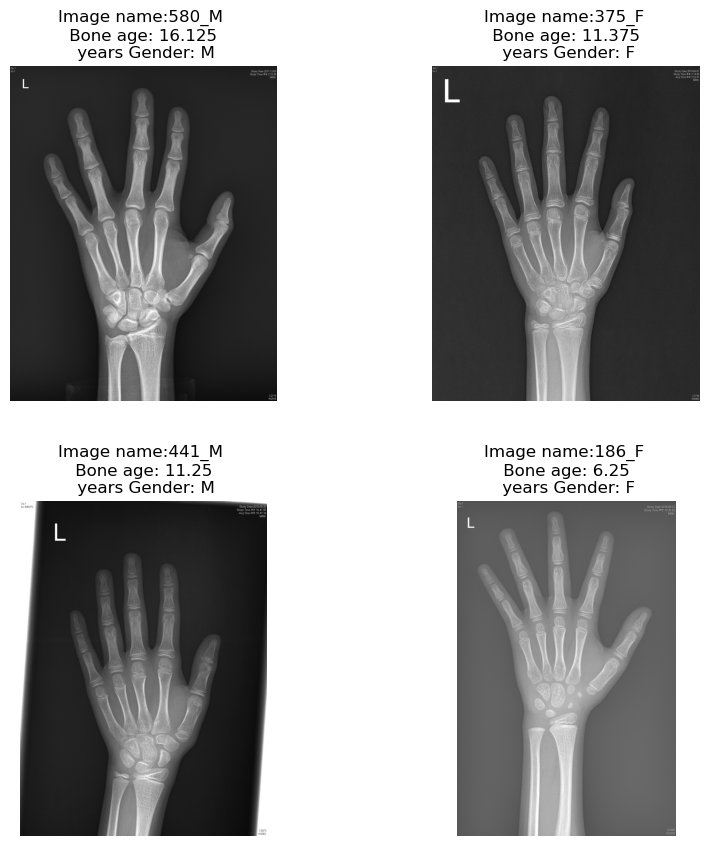

In [57]:
import matplotlib.image as mping
fig, axes = plt.subplots(2,2, figsize = (10, 10))
plt.subplots_adjust(hspace=0.3)
i = 0
for filename, boneage, gender in df[['new_id', 'boneage', 'gender']].sample(4).values:
    img = mping.imread('./골밀도 데이터/data/' + filename + '.jpg')
    axes[i//2,i%2].imshow(img)
    axes[i//2,i%2].set_title('Image name:{} \n Bone age: {} \n years Gender: {}'.format(filename, boneage, gender))
    axes[i//2,i%2].axis('off')
    i += 1
    
plt.show()

## 2. 이미지 전처리

In [59]:
!pip install tensorflow

  Using cached absl_py-2.0.0-py3-none-any.whl.metadata (2.3 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 26.8 MB/s eta 0:00:00
  Using cached tensorboard_data_server-0.7.2-py3-none-manylinux_2_31_x86_64.whl.metadata (1.1 kB)
  Using cached rsa-4.9-py3-none-any.whl (34 kB)
  Using cached requests_oauthlib-1.3.1-py2.py3-none-any.whl (23 kB)
  Using cached oauthlib-3.2.2-py3-none-any.whl (151 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 16.5 MB/s eta 0:00:0000:0100:01
Using cached absl_py-2.0.0-py3-none-any.whl (130 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 101.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 103.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.9/22.9 MB 84.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 107.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━

In [58]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from  keras.applications.xception import preprocess_input 

ModuleNotFoundError: No module named 'tensorflow'

In [52]:
data_path = '골밀도 데이터/data/'

In [53]:
img_path = data_path + str(df.ID[0]) +'_M.jpg'
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
img.shape #shape 확인

(1560, 1344)

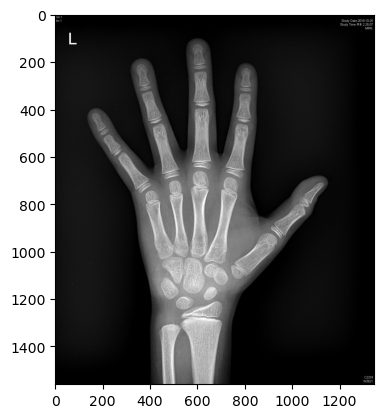

In [54]:
plt.imshow(img, 'gray')
plt.show()

__Resize__

In [55]:
#이미지 가로 세로 비율 확인
img.shape[0]/img.shape[1]

1.1607142857142858

In [58]:
#이미지 사이즈 재설정 (기존 1.25비율 유지)
resized_img=cv2.resize(img,(1024,1280))

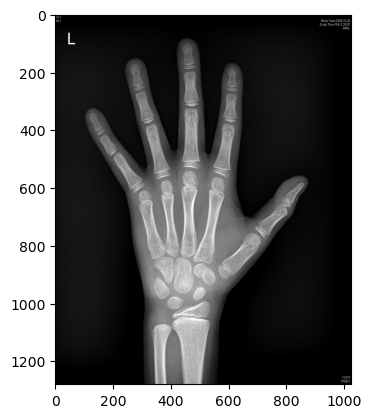

In [59]:
#resized 이미지 확인
plt.imshow(resized_img,"gray")

__Normalize__

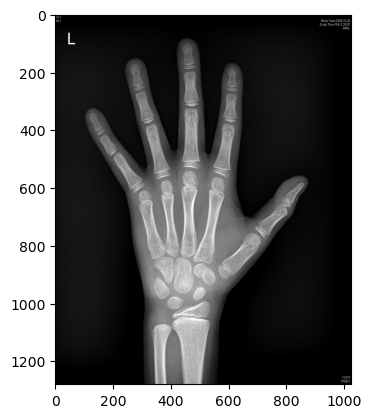

In [61]:
#이미지 min max 정규화
normal_img=cv2.normalize(resized_img, None, 0, 255, cv2.NORM_MINMAX)
plt.imshow(normal_img,"gray")

__Denoise__

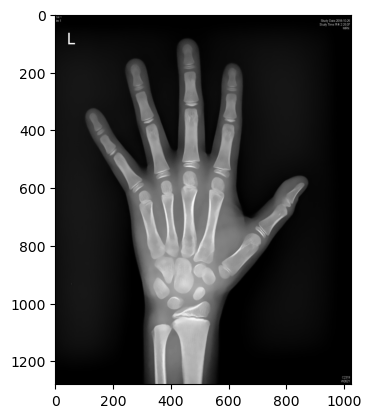

In [63]:
#이미지 노이즈 제거
    #제거 강도: 20
    #templateWindowSize :5
    #searchWindowSize : 15
denoise_img=cv2.fastNlMeansDenoising(normal_img, None, 20, 5, 15)
plt.imshow(denoise_img,"gray")

__Equalize__

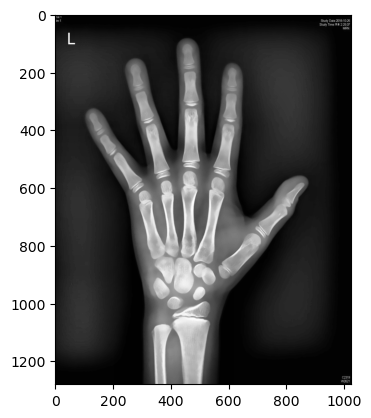

In [64]:
#이미지 평탄화
    #cv2.equalizeHist 사용시 전체 기준이므로 contrast가 날아가는 문제 발생
    #따라서 bin 구간 나누어 평탄화 가능한 clahe로 평탄화 수행
    #clipLimit: 2
    #tileGridSize: 5 x 5
clahe = cv2.createCLAHE(clipLimit=2, tileGridSize=(5,5))
equal_img=clahe.apply(denoise_img)
plt.imshow(equal_img,"gray")